In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nussl
from utils import viz, data
import yaml
import os

In [22]:
import json
from nussl.datasets import transforms as nussl_tfm
from pathlib import Path

In [36]:
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
from models.Filterbank import Filterbank
nussl.ml.register_module(MaskInference)
nussl.ml.register_module(UNetSpect)
nussl.ml.register_module(Filterbank)

In [24]:
os.listdir('models/')

['ST_mask_0.1dropout',
 '.ipynb_checkpoints',
 'test_filterbank',
 '__pycache__',
 'MaskInference.py',
 'Waveform.py',
 'UNet.py',
 'Filterbank.py',
 'ST_mask_1layer',
 'ST_mask_0.5dropout',
 'ST_mask_5layer',
 'Clustering.py',
 'ST_mask_3layer',
 'ST_mask_tutorial_defaults']

In [25]:
model_name = 'test_filterbank'

In [26]:
model_path = 'models/'+model_name+'/checkpoints/latest.model.pth'
config_path = 'models/'+model_name+'/configs.yml'
#Optimizer checkpoints no longer stored
#optimizer_path = 'models/'+model_name+'/checkpoints/latest.optimizer.pth'

In [37]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()

model_type = configs['model_type']
waveform_models = ['Filterbank']
if model_type in waveform_models:
    stft_params = None
    
    separator = nussl.separation.deep.DeepAudioEstimation(
        nussl.AudioSignal(), model_path='overfit/checkpoints/latest.model.pth',
        device='cpu',
    )
else:
    stft_params = nussl.STFTParams(**configs['stft_params'])
    
    separator = nussl.separation.deep.DeepMaskEstimation(
        nussl.AudioSignal(), model_path=model_path,
        device='cpu',
    )

In [38]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
#Optimizer checkpoints no longer stored
#optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [39]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 10,
 'epoch_length': 10,
 'max_epochs': 10,
 'output': {'loss': 0.004139586351811886},
 'metrics': {'avg_loss': 0.004067020931398079},
 'seed': None}

In [40]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

Text(0.5, 0, 'Epoch')

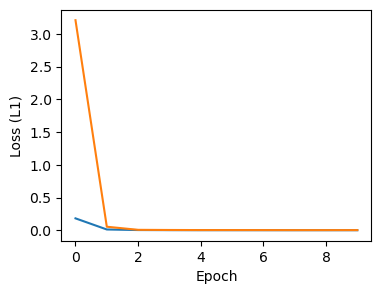

In [41]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss)
plt.plot(x,train_loss)
plt.ylabel('Loss (L1)')
plt.xlabel('Epoch')

In [33]:
test_data[0]

{'mix': <nussl.core.audio_signal.AudioSignal at 0x7f1f504ffb80>,
 'sources': {'vocals': <nussl.core.audio_signal.AudioSignal at 0x7f1f54ecbe50>,
  'drums': <nussl.core.audio_signal.AudioSignal at 0x7f1f504554e0>,
  'bass': <nussl.core.audio_signal.AudioSignal at 0x7f1f50455630>,
  'other': <nussl.core.audio_signal.AudioSignal at 0x7f1f50457f70>},
 'metadata': {'jam': <JAMS(file_metadata=<FileMetadata(...)>,
        annotations=[1 annotation],
        sandbox=<Sandbox(...)>)>,
  'idx': 0}}

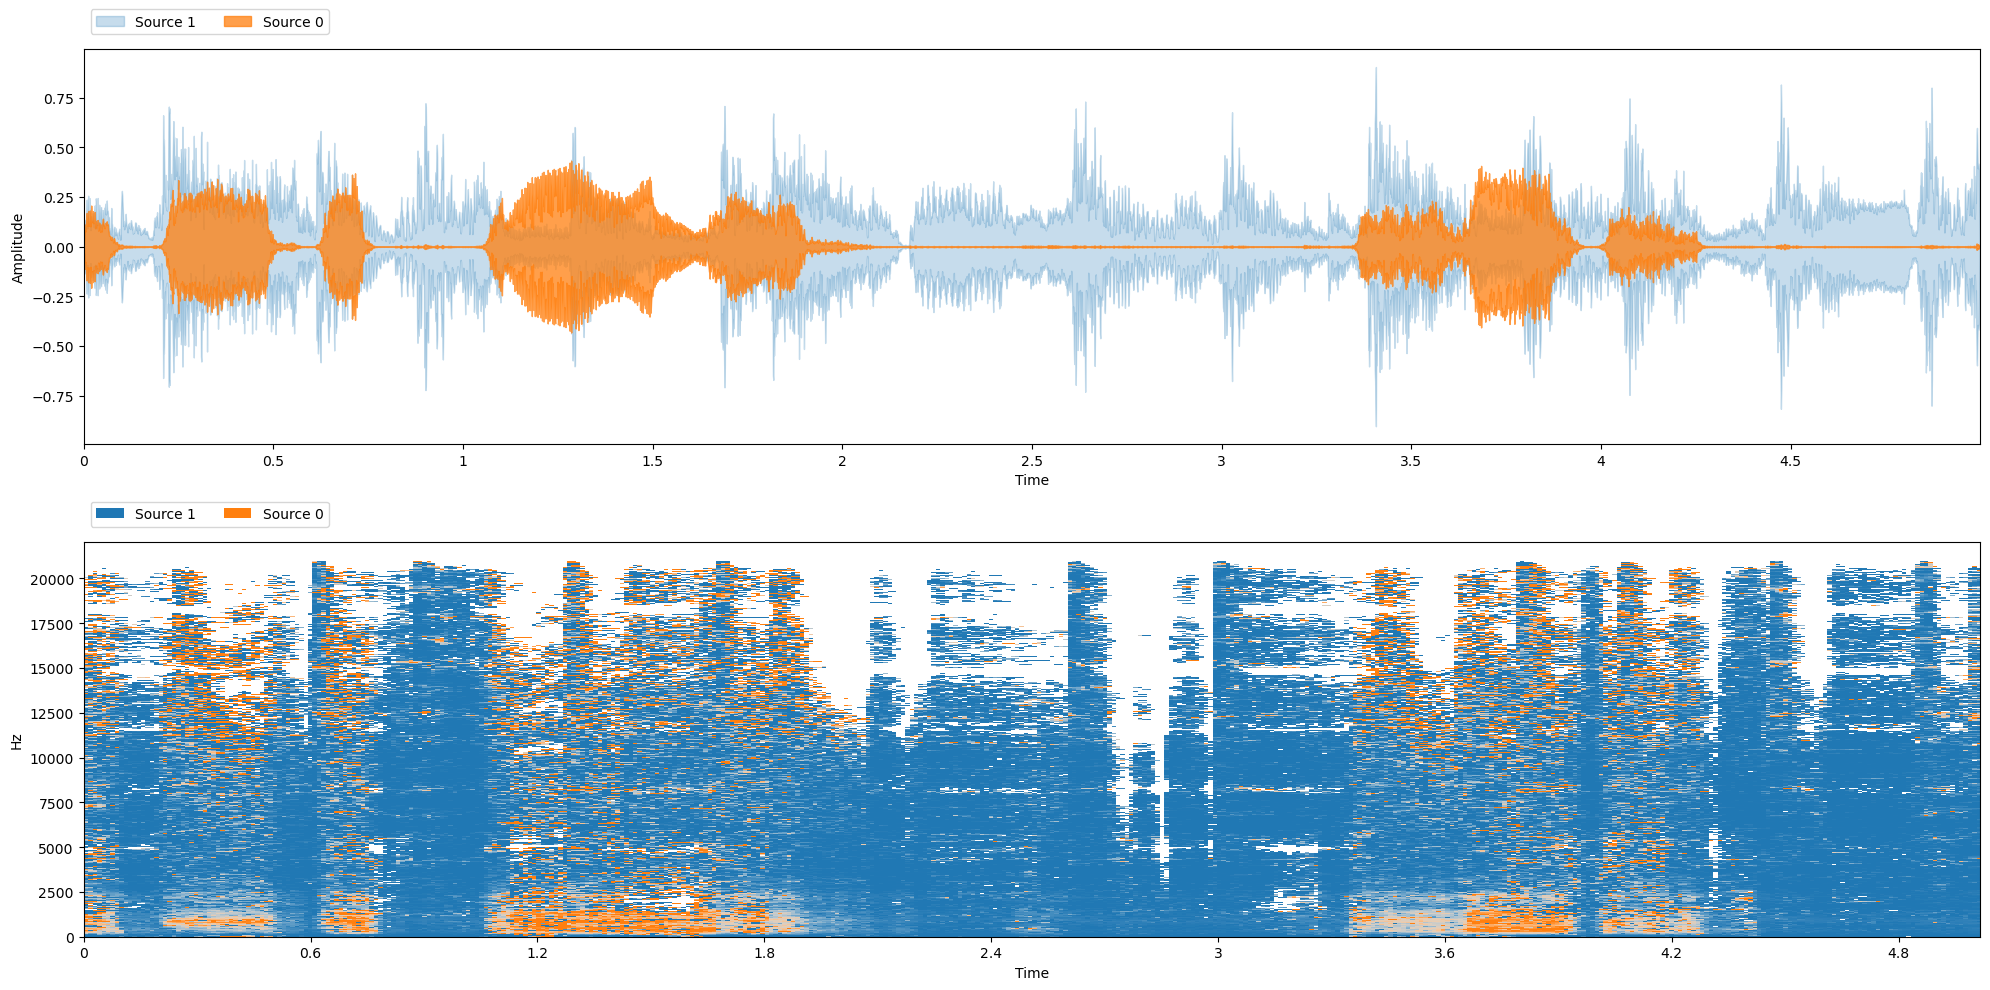


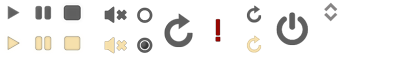
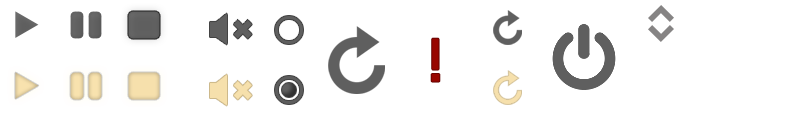
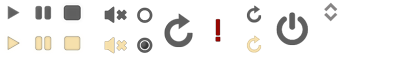

In [42]:
#Test on the data
test_folder = configs['test_folder']
tfm = None
test_data = data.mixer(stft_params, transform=tfm, fg_path=configs['test_folder'], num_mixtures=50, coherent_prob=1.0, duration=5)

item = test_data[1]
separator.audio_signal = item['mix']
estimates = separator()
estimates.append(item['mix'] - estimates[0])

viz.show_sources(estimates)